# Modelos de predicción del tráfico en cruces semafóricos de Madrid - Primera Parte

A continuación vamos a cargar la información de los resultados de los puntos de medición del tráfico en un dataframe de pandas, con el objetivo de realizar un estudio de aquellos puntos de medición de mayor congestión. Para ello utilizaremos los datos del mes de noviembre de 2021, teniendo en cuenta que el mes de diciembre no sería representativo por la presencia de vacaciones de navidad.

In [2]:
# Librerías
from google.colab import drive
import zipfile
from io import BytesIO
import requests
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
import statistics
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Path
# Montamos la unidad
drive.mount('/content/drive')

# Añadimos el path
%cd /content/drive/MyDrive/Ciencia de datos/TFM/Final Version

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1D-BEHc4GwG5jHLByXBua1fkmrsIs1Flr/Ciencia de datos/TFM/Final Version


## 1. Carga de los ficheros

### 1.1 Información del tráfico

A continuación realizaremos la carga de los siguientes ficheros relativos a la información del tráfico:
    - Datos de los resultados puntos de medidas del tráfico (en adelante pmt) en Madrid durante el mes de noviembre de 2021. Destacar que en el apartado Selección del universo se cargarán datos con mayor profundidad histórica. No se realiza en este punto debido a que el volumen para todos los pmt es inmanejable.
    - Datos de los pmt
    - Datos de los cruces semafóricos de Madrid

In [20]:
# Carga de los resultados de los pmt
url = 'https://datos.madrid.es/egob/catalogo/208627-102-transporte-ptomedida-historico.zip'
buf1 = BytesIO( requests.get(url).content)
f = zipfile.ZipFile(buf1, "r")
df_pmed = pd.read_csv(f.open(f.namelist()[0]),  sep=';')

# Carga de los datos de la ubicación de los pmt
df_pmed_ub = pd.read_csv('Datos/Puntos de medición/pmed_ubicacion_01-2022.csv', sep=';')


### 1.2 Climatología

Carga de los datos históricos de meteorología de Madrid y selección de las variables relevantes

In [23]:
# Carga de los datos meteorológicos
df_meteo = pd.read_csv('Datos/Meteo/Meteo_Madrid.csv', sep=';')

# Selección de las columnas que necesitamos
df_meteo = df_meteo[["fecha", "prec"]]

# Renombrado de las columnas
df_meteo.rename(columns = {'prec':'precipitaciones'}, inplace = True)

# Comprobación
df_meteo.head()

,fecha,precipitaciones
0,2017-01-01,0
1,2017-01-02,0
2,2017-01-03,Ip
3,2017-01-04,0
4,2017-01-05,0


### 1.3 Calendario Laboral 

Carga del histórico del calendario laboral de Madrid y selección de variables relevantes:

In [46]:
# Carga de los datos del calendario laboral
df_callab = pd.read_csv('Datos/Calendario laboral/Calendario Laboral Madrid.csv', sep=';')

# Selección de las columnas que necesitamos
df_callab = df_callab[["Día","Día_semana", "laborable / festivo / domingo festivo"]]

# Renombrado de las columnas
df_callab.rename(columns = {'Día':'fecha', 'Día_semana':'dia_semana','laborable / festivo / domingo festivo':'tipo_dia'}, inplace = True)

# Comprobación
df_callab.head(5)

,fecha,dia_semana,tipo_dia
0,01/01/2013,martes,festivo
1,02/01/2013,miércoles,laborable
2,03/01/2013,jueves,laborable
3,04/01/2013,viernes,laborable
4,05/01/2013,sábado,sábado


## 2. Selección del universo

### 2.1 PMT más concurrido y carga del histórico

A continuación, cruzamos el fichero de los resultados de los puntos de medición con la ubicación de cada uno de ellos

In [26]:
# Cruzamos los ficheros por el id del punto de medición
df_pmed_pmed_ub = df_pmed.set_index('id').join(df_pmed_ub.set_index('id'), how='inner', lsuffix='_1', rsuffix='_2')

# Eliminamos los puntos de medición de la M30 (Circunvalación), puesto que únicamente nos interesan las zonas urbanas
mask = (df_pmed_pmed_ub['tipo_elem_1'] == "URB") 
df_pmed_pmed_ub = df_pmed_pmed_ub.loc[mask]

# A continuación, calcularemos la media de intensidad del tráfico de cada uno de los puntos de medición urbanos de Madrid y la ordenaremos descendentemente. El objetivo en este caso es mostrar los 20 puntos de medición que más intensidad de tráficos sufren de media.
df_pmed_pmed_ub.groupby(['id', 'distrito'])['intensidad'].mean().reset_index(name='mean').sort_values(['mean'], ascending=False).head(20)

,id,distrito,mean
3464,10395,10.0,2143.271553
594,4113,2.0,1997.514425
1221,4822,17.0,1985.489013
3465,10397,10.0,1949.455432
261,3716,9.0,1892.221329
3036,7136,2.0,1864.396941
855,4419,7.0,1801.228015
2984,7021,7.0,1783.301913
1696,5333,10.0,1779.214563
3039,7139,1.0,1727.014251


Una vez generada la lista de los puntos de medición con mayor intensidad de tráfico de media durante noviembre de 2021, hemos realizado un análisis de los 20 principales, generando un cuadro de cruces que nos indica para cada uno de ellos cuales son los puntos de medición que lo conforman y cómo están distribuidos. A continuación cargaremos este cuadro:

In [27]:
# Cargamos la selección de los cruces
cruces_seleccion = pd.read_csv('Datos/Cruces semaforizados/[DEF] Selección cruces.csv', sep=';')

# Mostramos
pd.DataFrame(cruces_seleccion)

,pmed clave,id cruce,Este-Cruce,Cruce-Este,Norte-Cruce,Cruce-Norte,Oeste-Cruce,Cruce-Oeste,Sur-Cruce,Curce-Sur
0,4826,1188,4837.0,5345.0,3802.0,4829.0,4975.0,4827.0,4825.0,4826.0
1,9892,169,NaN,4012.0,NaN,9892.0,3972.0,NaN,3757.0,NaN
2,10067,1640,10309.0,NaN,10067.0,NaN,NaN,NaN,10069.0,NaN
3,4437,85,4443.0,NaN,NaN,4437.0,4442.0,NaN,4444.0,4436.0
4,5457,59,5473.0,NaN,5456.0,5459.0,5715.0,5472.0,5458.0,5457.0
5,7018,103,7018.0,NaN,NaN,NaN,NaN,7021.0,NaN,7069.0
6,7139,64,3463.0,3718.0,7139.0,7138.0,NaN,NaN,4197.0,7136.0
7,5333,910,NaN,5334.0,NaN,5333.0,NaN,5160.0,NaN,5328.0
8,4419,76,4421.0,NaN,NaN,7069.0,NaN,4419.0,4424.0,NaN
9,3716,208,3396.0,3397.0,4470.0,NaN,3715.0,3716.0,7066.0,3717.0


A continuación, cargaremos todos los ficheros históricos de medición del tráfico desde 2019 hasta 2022, manteniendo los registros de los puntos de medición que vamos a analizar y descartando los demás

In [28]:
# Definimos variable donde cargaremos los ids de los puntos de medición
puntos_medición = []

# Recorremos el df  para ir incorporando los ids
for i in range(2, 3):
    puntos_medición.extend(cruces_seleccion.iloc[:, i].values.tolist())
    
#Eliminamos los valores 'nan'
puntos_medición = [i for i in puntos_medición if str(i) != 'nan']

#Comprobamos el número de puntos de medición que debemos analizar
print('El número de puntos de medición a analizar es: ' +str(len(puntos_medición)))

El número de puntos de medición a analizar es: 8


In [29]:
# Definimos listas donde incorporamos las fechas de los históricos que tenemos disponibles
pre_url = 'https://datos.madrid.es/egob/catalogo/208627-'
fich = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102, 103]
post_url = '-transporte-ptomedida-historico.zip'

# Definimos variables de control
c1 = 1
df_pmt=pd.DataFrame()

# Recorremos las listas para cargar los ficheros
for x in fich:
    print('Cargando fichero '+str( c1)+' de '+str( len(fich))+'. Volumen total: '+ str(df_pmt.shape))
    url = pre_url + str(x) + post_url
    # Si es el primer fichero que cargamos
    if (c1==1):
        buf1 = BytesIO( requests.get(url).content)
        f = zipfile.ZipFile(buf1, "r")
        df_pmt = pd.read_csv(f.open(f.namelist()[0]), sep=';')
        df_pmt = df_pmt[df_pmt['id'].isin(puntos_medición)]
    # Si ya hemos cargado ficheros anteriores
    else:
        buf1 = BytesIO( requests.get(url).content)
        f = zipfile.ZipFile(buf1, "r")
        df_temp = pd.read_csv(f.open(f.namelist()[0]), sep=';')
        df_temp = df_temp[df_temp['id'].isin(puntos_medición)]
        df_pmt = df_pmt.append(df_temp, ignore_index=True)
    c1 = c1+1

Cargando fichero 1 de 36. Volumen total: (0, 0)
Cargando fichero 2 de 36. Volumen total: (23751, 9)
Cargando fichero 3 de 36. Volumen total: (45208, 9)
Cargando fichero 4 de 36. Volumen total: (68755, 9)
Cargando fichero 5 de 36. Volumen total: (91112, 9)
Cargando fichero 6 de 36. Volumen total: (114798, 9)
Cargando fichero 7 de 36. Volumen total: (136720, 9)
Cargando fichero 8 de 36. Volumen total: (158117, 9)
Cargando fichero 9 de 36. Volumen total: (181792, 9)
Cargando fichero 10 de 36. Volumen total: (204705, 9)
Cargando fichero 11 de 36. Volumen total: (228245, 9)
Cargando fichero 12 de 36. Volumen total: (251219, 9)
Cargando fichero 13 de 36. Volumen total: (274907, 9)
Cargando fichero 14 de 36. Volumen total: (298602, 9)
Cargando fichero 15 de 36. Volumen total: (320738, 9)
Cargando fichero 16 de 36. Volumen total: (343901, 9)
Cargando fichero 17 de 36. Volumen total: (365855, 9)
Cargando fichero 18 de 36. Volumen total: (386237, 9)
Cargando fichero 19 de 36. Volumen total: (406

Por último, nos quedaremos con el punto de medida más frecuentado, que será el que utilicemos para modelar. Adicinalmente, utilizaremos el campo fecha como índice del dataframe:

In [30]:
df_pmt_3396 = df_pmt[df_pmt['id']==3396]

# Convertir la fecha en date e index
df_pmt_3396['fecha'] = pd.to_datetime(df_pmt_3396['fecha'], format='%Y-%m-%d %H:%M')
df_pmt_3396 = df_pmt_3396.set_index('fecha')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 2.2 Climatología

In [31]:
# Convertimos el campo fecha en datetime
df_meteo['fecha'] = pd.to_datetime(df_meteo['fecha'], format='%Y-%m-%d')

# La seleccionamos como índice
df_meteo = df_meteo.set_index('fecha')

# Seleccionamos la profundidad de 3 años
df_meteo = df_meteo.truncate(before='2019-01-01', after='2021-12-31')

# Comprobamos el tamaño
df_meteo.shape

(1096, 1)

### 2.3 Calendario laboral

In [47]:
# Pendiente

# Eliminamos las filas que no tienen fecha
df_callab = df_callab[df_callab['fecha'].notna()]

# Comprobamos
print('La columna fecha tiene '+str(df_callab['fecha'].isnull().sum()) +' valores nulos')

# Convertimos la columna fecha en tipo datetime
df_callab['fecha'] = pd.to_datetime(df_callab['fecha'], format='%d/%m/%Y')

# La seleccionamos como índice
df_callab = df_callab.set_index('fecha')

# Seleccionamos la profundidad de 3 años
df_callab = df_callab.truncate(before='2019-01-01', after='2021-12-31')

# Comprobamos el tamaño
df_callab.shape


La columna fecha tiene 0 valores nulos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(1096, 2)

## 3. Limpieza y preparación de los datos

### 3.1 Información del tráfico

A continuación vamos a fijar la frecuencia de los datos y a revisar los principales datos estadísticos y la presencia de valores atípicos y perdidos y realizaremos imputaciones sobre estos últimos. Destacar que en última instancia nos quedaremos únicamente con el índice del dataframe(fecha) y con la variable carga

In [33]:
# Comprobamos los registros según definición que tienen error para descartarlos
print('Tenemos ' + str(df_pmt_3396[df_pmt_3396['error']!='N'].shape[0]) + ' registros con error') # Observamos que no hay ningún valor con error

# Nos quedamos únicamente con la variable carga
df_pmt_3396=df_pmt_3396['carga']

# Buscamos valores perdidos de nuestra variable
print('Tenemos ' + str(df_pmt_3396.isnull().sum()) + ' valores perdidos')

# Por último, comprobaremos si nuestro index de fecha tiene alguna laguna con respecto a la frecuencia de 15 min

#df_3396['carga'].asfreq('15T', method='pad').isna()
print('Tras incorporar las franjas inexistentes, tenemos ' + str(df_pmt_3396.asfreq('15T').isnull().sum()) + ' valores perdidos')




Tenemos 0 registros con error
Tenemos 0 valores perdidos
Tras incorporar las franjas inexistentes, tenemos 6982 valores perdidos


In [34]:
# Rellenamos los los valores perdidos generados con el último valor correcto
df_pmt_3396 = df_pmt_3396.asfreq('15T', method = 'pad')

# Comprobamos
print('Una vez corregidos los valores perdidos tenemos ' + str(df_pmt_3396.isnull().sum()) + ' valores perdidos\n')

# A continuación revisamos los valores de nuestra variable carga
print(df_pmt_3396.describe())

Una vez corregidos los valores perdidos tenemos 0 valores perdidos

count    105215.000000
mean         10.952070
std          11.864505
min           0.000000
25%           4.000000
50%           8.000000
75%          13.000000
max         100.000000
Name: carga, dtype: float64


### 3.2 Climatología

In [35]:
# Comprobamos valores nulos
print('Tenemos ' + str(df_meteo.isnull().sum()[0]) + ' valores perdidos\n')

# Revisamos los valores de la columna precipitaciones
print(df_meteo['precipitaciones'].unique())

#Vemos que la columna precipitaciones tiene el valor Ip. En la descripción se indica que se corresponde con un valor inferior a 0.1mm. Indicaremos 0.1
df_meteo.loc[df_meteo['precipitaciones'] == 'Ip', 'precipitaciones'] = '0,1'

df_meteo['precipitaciones'] = df_meteo['precipitaciones'].str.replace(',','.')

# Convertimos la columna precipitaciones a number
df_meteo['precipitaciones'] = pd.to_numeric(df_meteo['precipitaciones'])

df_meteo.describe()

Tenemos 0 valores perdidos

['0' '5,9' '0,4' 'Ip' '4,1' '8,2' '1' '1,6' '2' '1,3' '2,7' '3,5' '4,3'
 '0,2' '0,8' '21,6' '7,7' '6,8' '0,3' '0,7' '2,8' '28,5' '0,1' '6,2'
 '16,2' '4,2' '26,9' '10,6' '13,7' '1,7' '6,7' '5,4' '3,2' '0,6' '2,3'
 '18,4' '0,5' '10,1' '1,5' '1,8' '1,4' '3,9' '5,2' '8,8' '2,5' '7,8'
 '26,8' '0,9' '1,2' '38,4' '12,8' '3' '2,2' '9,5' '4' '9,8' '18,2' '7,2'
 '14,2' '2,4' '1,1' '18,1' '3,3' '19,3' '9' '11,4' '13,2' '37,8' '4,5'
 '26,6' '3,4' '13' '22,2' '6,6' '6,9' '7,5' '4,4' '24,2' '9,6' '3,8' '6,4'
 '20' '4,6' '1,9' '32,9' '17,7' '3,1' '7,9' '12,3' '10' '29,6' '12,6'
 '18,8' '3,7' '6,3' '40,4' '5,7' '6,1' '3,6' '32,5' '5,8' '27,1' '14'
 '38,9' '11,8' '67,7' '47,7' '8,5' '11,5']


,precipitaciones
count,1096.000000
mean,1.359033
std,5.006723
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,67.700000


In [36]:
print('Tenemos ' + str(df_meteo.isnull().sum()[0]) + ' valores perdidos\n')
print('Si incorporamos las franjas inexistentes tendríamos ' + str(df_meteo.asfreq('D').isnull().sum()[0]) + ' valores perdidos')
df_meteo = df_meteo.asfreq('D', method = 'pad')
print('Una vez corregidos los valores perdidos tenemos ' + str(df_meteo.isnull().sum()[0]) + ' valores perdidos\n')

Tenemos 0 valores perdidos

Si incorporamos las franjas inexistentes tendríamos 0 valores perdidos
Una vez corregidos los valores perdidos tenemos 0 valores perdidos



### 3.3 Calendario laboral

In [48]:
# Tenemos como objetivo
print('dia_semana: tenemos ' + str(df_callab['dia_semana'].isnull().sum()) + ' valores perdidos\n')
print('tipo_dia: tenemos ' + str(df_callab['tipo_dia'].isnull().sum()) + ' valores perdidos\n')

# Revisamos los valores de tipo_dia
print(df_callab.groupby(['tipo_dia'])['tipo_dia'].count())

# Corregimos las mayúsculas y minúsculas de los festivos
df_callab.loc[df_callab['tipo_dia'] == 'Festivo', 'tipo_dia'] = 'festivo'

# Incorporamos en tipo_dia los sábados y domingos de dia.semana
df_callab.loc[df_callab['dia_semana'] == 'sábado', 'tipo_dia'] = 'sabado'
df_callab.loc[df_callab['dia_semana'] == 'domingo', 'tipo_dia'] = 'domingo'

# Unificamos domingos y festivos
df_callab.loc[df_callab['tipo_dia'] == 'domingo', 'tipo_dia'] = 'domingo/festivo'
df_callab.loc[df_callab['tipo_dia'] == 'festivo', 'tipo_dia'] = 'domingo/festivo'

# Resto de días serán laborables
df_callab.loc[df_callab['tipo_dia'].isna()] = 'laborable'

#Revisamos
print('\nTras corregir los valores perdidos tenemos ' + str(df_callab['tipo_dia'].isnull().sum()) + ' valores perdidos\n')
print(df_callab.groupby(['tipo_dia'])['tipo_dia'].count())

# Por último, convertiremos la variable tipo_dia en binaria
df_callab['domingo/festivo'] = 0
df_callab['laborable'] = 0
df_callab['sabado'] = 0

df_callab.loc[df_callab['tipo_dia'] == 'domingo/festivo', 'domingo/festivo'] = 1
df_callab.loc[df_callab['tipo_dia'] == 'laborable', 'laborable'] = 1
df_callab.loc[df_callab['tipo_dia'] == 'sabado', 'sabado'] = 1

# Eliminamos las variables originales
del df_callab['dia_semana']
del df_callab['tipo_dia']

# Comprobamos
df_callab.head(5)


dia_semana: tenemos 0 valores perdidos

tipo_dia: tenemos 1049 valores perdidos

tipo_dia
Festivo      24
domingo       1
festivo      18
laborable     3
sábado        1
Name: tipo_dia, dtype: int64

Tras corregir los valores perdidos tenemos 0 valores perdidos

tipo_dia
domingo/festivo    191
laborable          749
sabado             156
Name: tipo_dia, dtype: int64


,domingo/festivo,laborable,sabado
fecha,,,
2019-01-01,1,0,0
2019-01-02,0,1,0
2019-01-03,0,1,0
2019-01-04,0,1,0
2019-01-05,0,0,1


## 4. Análisis de la estacionaridad de los datos

Text(0.5, 1.0, '4-11-2021')

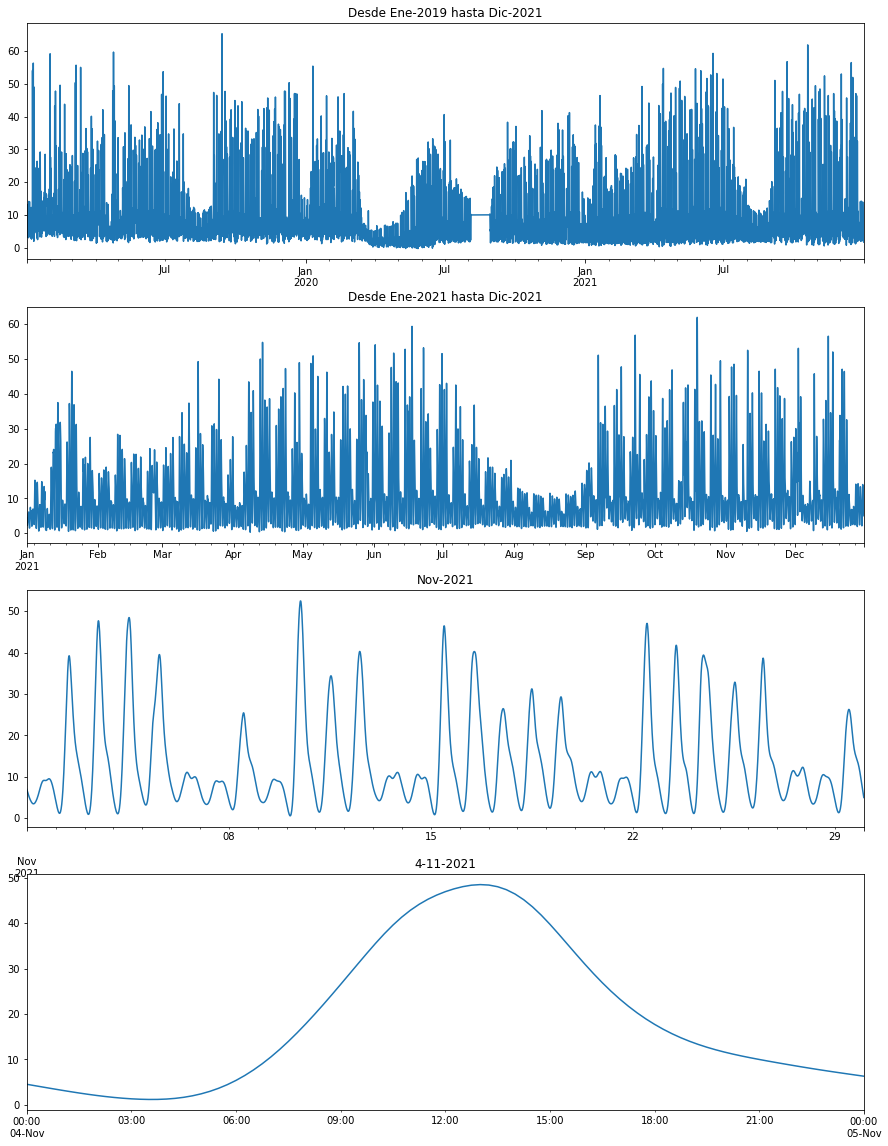

In [50]:
# Revisamos tendencias en los datos

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(15,20))
#fig.suptitle('Análisis de la tendencia')

# En primer luegar revisaremos la progresión del indicador para todo el periodo (3 años)
df_cycle,df_trend_1 = hpfilter(df_pmt_3396, lamb=1600)
df_trend_1.plot(ax=ax1).autoscale(axis=ax1,tight=True)
ax1.set_xlabel(None)
ax1.set_title("Desde Ene-2019 hasta Dic-2021")

# En segundo lugar
temp = df_pmt_3396.truncate(before='2021-01-01', after='2021-12-31')
df_cycle,df_trend_2 = hpfilter(temp, lamb=1600)
df_trend_2.plot(ax=ax2).autoscale(axis=ax2,tight=True)
ax2.set_xlabel(None)
ax2.set_title("Desde Ene-2021 hasta Dic-2021")

# En tercer lugar para 1 mes (elegimos uno sin fechas señaladas tipo vacaciones)
temp = df_pmt_3396.truncate(before='2021-11-01', after='2021-11-30')
df_cycle,df_trend_3 = hpfilter(temp, lamb=1600)
df_trend_3.plot(ax=ax3).autoscale(axis=ax3,tight=True)
ax3.set_xlabel(None)
ax3.set_title("Nov-2021")

# En cuarto lugar para un día (elegimos uno laborable)
temp = df_pmt_3396.truncate(before='2021-11-04', after='2021-11-05')
df_cycle,df_trend_4 = hpfilter(temp, lamb=1600)
df_trend_4.plot( ax=ax4).autoscale(axis=ax4,tight=True)
ax4.set_xlabel(None)
ax4.set_title("4-11-2021")

A continuación vamos a descomponer los datos para encapsular y detectar la si existe alguna tendencia, estacionalidad/variaciones cícliclas y los residuos. Modificaremos el intervalo y la profundidad de los datos para poder ser más específicos.

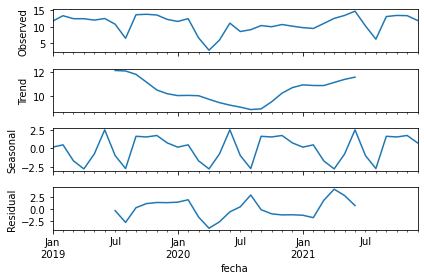

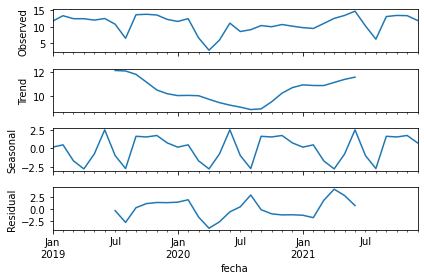

In [51]:
# Intervalo mensual
sm.tsa.seasonal_decompose(df_pmt_3396.resample('1M').mean(), model='add').plot()

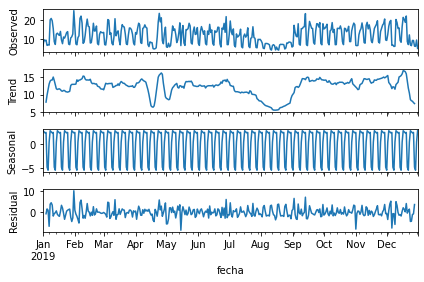

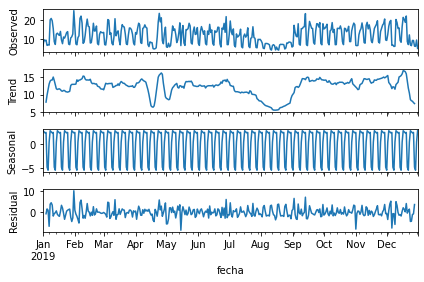

In [52]:
#Intervalo diario en 2019
temp = df_pmt_3396.truncate(before='2019-01-01', after='2019-12-31')
sm.tsa.seasonal_decompose(temp.resample('1D').mean(), model='add').plot()

Por último, podemos utilizar el test de adfuller para verificar si nuestros datos son estacionarios.En concreto el contraste sería:
H0: los datos no son estacionarios
H1: los datos son estacionarios

In [59]:
import arch
from arch.unitroot import KPSS, ADF
ADF(df_pmt_3396)

Test Statistic,-34.443
P-value,0.000
Lags,69


EL segundo valor corresponde al p-valor. Como podemos observar, el p-valor es 0 y por tanto inferior a 5%, por lo que rechazamos la hipótesis nula y podemos decir con un 95% de confianza que nuestros datos son estacionarios.

## 5. Combinación, granularidad, profundidad de los datos y normalización

### 5.1 Granularidad y profundidad histórica de los datos

In [60]:
# filtramos por los datos de 2019
df_pmt_3396_2019H = df_pmt_3396.truncate(before='2019-01-01', after='2019-12-31')

# Cambiamos la frecuencia a 1 por hora
df_pmt_3396_2019H = temp.resample('1H').mean()

# Datasets para los modelos univariables y multivariables
df_pmt_3396_2019H_uni = df_pmt_3396_2019H.to_frame()
df_pmt_3396_2019H_multi = df_pmt_3396_2019H

### 5.2 Combinación de datasets

In [61]:
# Creamos variables para hacer join y reestablecer el index
df_pmt_3396_2019H_multi = df_pmt_3396_2019H.to_frame()
df_pmt_3396_2019H_multi['fecha1'] = df_pmt_3396_2019H_multi.index
df_pmt_3396_2019H_multi['fecha2'] = df_pmt_3396_2019H_multi.index
df_pmt_3396_2019H_multi['fecha1'] = pd.to_datetime(df_pmt_3396_2019H_multi['fecha1'], format='%Y-%m-%d %H:%M:%S')
df_pmt_3396_2019H_multi['fecha2'] = pd.to_datetime(df_pmt_3396_2019H_multi['fecha2']).dt.normalize()

# Realizamos los join
df_pmt_3396_2019H_multi = pd.merge(df_pmt_3396_2019H_multi, df_callab, how="left", left_on='fecha2', right_on = 'fecha')
df_pmt_3396_2019H_multi = pd.merge(df_pmt_3396_2019H_multi, df_meteo, how="left", left_on='fecha2', right_on = 'fecha')

# Reestablecemos el index
df_pmt_3396_2019H_multi.rename(columns = {'fecha1':'fecha'}, inplace = True)
df_pmt_3396_2019H_multi = df_pmt_3396_2019H_multi.set_index('fecha')

# Eliminamos variable auxiliar
del df_pmt_3396_2019H_multi['fecha2']

# Comprobamos
df_pmt_3396_2019H_multi.head()

,carga,domingo/festivo,laborable,sabado,precipitaciones
fecha,,,,,
2019-01-01 00:00:00,4.333333,1,0,0,0.0
2019-01-01 01:00:00,13.250000,1,0,0,0.0
2019-01-01 02:00:00,19.000000,1,0,0,0.0
2019-01-01 03:00:00,4.250000,1,0,0,0.0
2019-01-01 04:00:00,4.000000,1,0,0,0.0


### 5.3 Exportación de los datos preprocesados

In [63]:
# Guardamos en local los datos preprocesados
df_pmt_3396_2019H_uni.to_csv("Datos/Tratados/df_pmt_3396_2019H_uni.csv") 
df_pmt_3396_2019H_multi.to_csv("Datos/Tratados/df_pmt_3396_2019H_multi.csv") 